### Домашнее задание
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv', ',')
df.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1
6,9,280.20,1,0,Surburban,1,Phone,Buy One Get One,0
7,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0
8,9,675.07,1,1,Rural,1,Phone,Discount,0
9,10,32.84,0,1,Urban,1,Web,Buy One Get One,0


In [3]:
df = df.rename(columns = {'conversion': 'target', 'offer': 'treatment'}, inplace = False)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [4]:
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0

In [5]:
#Создание dummy-переменных
df = pd.concat([df, pd.get_dummies(df['zip_code'])], axis=1)
df = df.drop(['zip_code'], axis=1)
df.head()

,recency,history,used_discount,used_bogo,is_referral,channel,treatment,target,Rural,Surburban,Urban
0,10,142.44,1,0,0,Phone,1,0,0,1,0
1,6,329.08,1,1,1,Web,0,0,1,0,0
2,7,180.65,0,1,1,Web,1,0,0,1,0
3,9,675.83,1,0,1,Web,1,0,1,0,0
4,2,45.34,1,0,0,Web,1,0,0,0,1


In [6]:
df_cat_value = df.groupby('recency', as_index=False).mean()[['recency', 'history']].rename(columns={
    'history': 'history_with_recency'
})
df_cat_value = pd.DataFrame(df_cat_value)
# df_cat
df = df.merge(df_cat_value, on='recency', how='left')

In [7]:
df = df.drop(['recency', 'history'], axis=1)
df.head()

,used_discount,used_bogo,is_referral,channel,treatment,target,Rural,Surburban,Urban,history_with_recency
0,1,0,0,Phone,1,0,0,1,0,172.104997
1,1,1,1,Web,0,0,1,0,0,218.387238
2,0,1,1,Web,1,0,0,1,0,207.557580
3,1,0,1,Web,1,0,1,0,0,185.874574
4,1,0,0,Web,1,0,0,0,1,310.990777


In [8]:
#разделим данные на train/test
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(df.drop('target', 1), df['target'], random_state=0)

In [9]:
indices_learn, indices_valid = train_test_split(X_train_full.index, test_size=0.3, random_state=0)

In [10]:
X_train_full.drop('treatment', 1).loc[indices_learn, :]

,used_discount,used_bogo,is_referral,channel,Rural,Surburban,Urban,history_with_recency
38171,1,0,0,Web,0,1,0,185.874574
39481,1,0,1,Phone,0,0,1,168.015759
19889,0,1,0,Multichannel,0,1,0,194.924066
53206,1,0,1,Web,0,0,1,168.015759
39530,0,1,0,Web,0,0,1,185.874574
...,...,...,...,...,...,...,...,...
24093,1,0,1,Web,0,1,0,207.557580
43198,1,1,1,Multichannel,0,1,0,251.310701
37512,0,1,1,Web,1,0,0,274.462007
3107,1,0,1,Multichannel,0,0,1,359.844955


In [11]:
X_train = X_train_full.drop('treatment', 1).loc[indices_learn, :]
y_train = y_train_full.loc[indices_learn]
treat_train = X_train_full.loc[indices_learn, 'treatment']

X_val = X_train_full.drop('treatment', 1).loc[indices_valid, :]
y_val = y_train_full.loc[indices_valid]
treat_val = X_train_full.loc[indices_valid, 'treatment']

In [12]:
cat_features = ['channel']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

uplift@10%: 0.1115
uplift@10%: 0.1110


array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

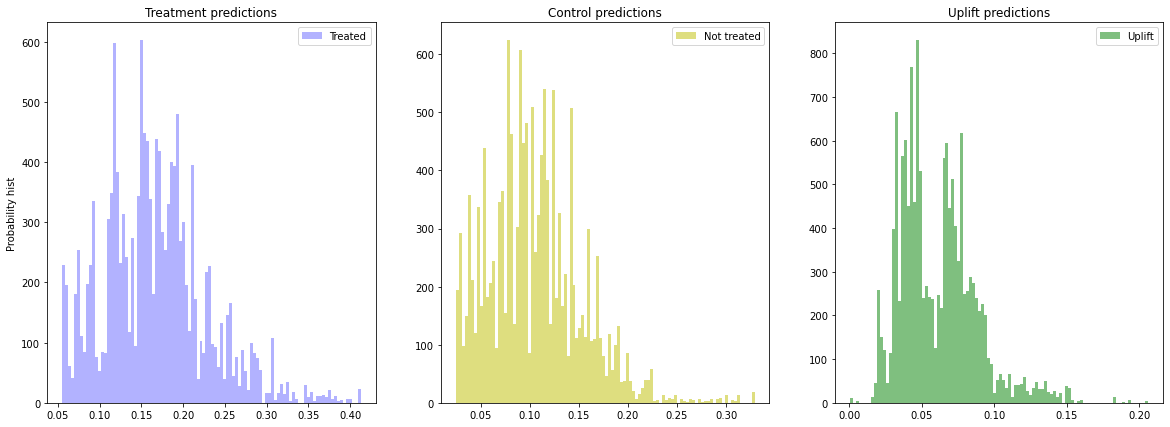

In [13]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score_10:.4f}')

sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@10%: {sm_score_20:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

In [14]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,20.561463
1,is_referral,20.022519
2,used_bogo,19.322881
3,used_discount,13.754171
4,history_with_recency,12.580270
5,channel,7.028464
6,Rural,5.628889
7,Urban,0.946148
8,Surburban,0.155196


In [15]:
from sklift.models import ClassTransformation

ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {ct_score_10:.4f}')
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {ct_score_20:.4f}')

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

<ipython-input-15-5f43fa95d58e>:4: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


uplift@10%: 0.0999
uplift@20%: 0.0937


uplift@10%: 0.1450
uplift@20%: 0.1070


array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

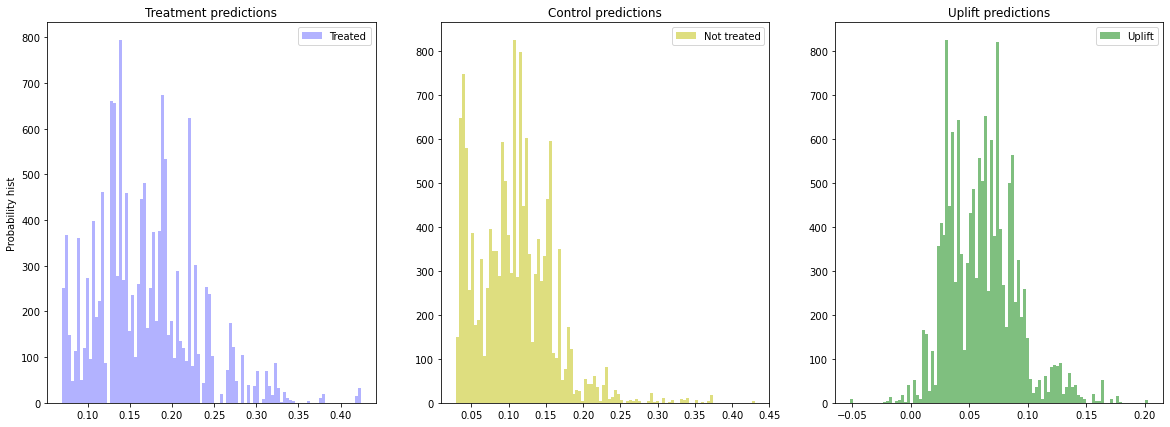

In [16]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {tm_score_10:.4f}')
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {tm_score_20:.4f}')

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

In [17]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
2,TwoModels,0.145018,0.106980
0,SoloModel,0.111534,0.110985
1,ClassTransformation,0.099935,0.093668
